# Quantum Convolutional Neural Network 

## <ins> Convolutional Architecture Building blocks <ins>

In this section, we design and test each part of the QCNN in comparison with PennyLane simulation to ensure the good simulation of the results.

In [13]:
import torch
from torch import nn
from scipy.special import binom

from PennyLane_toolbox import *
from toolbox import *

### <font color='red'>Conv Layer:</font>

We first start with the convolution layer.

In [2]:
from Conv_Layer import *

Let's define a common initial state that we can use to test our Pytorch simulation:

In [14]:
n, k = 8, 2
# Filter size:
K = 4

dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def circuit(angle):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, angle)
    RBS(4,5, angle)
    return qml.state()

# We express the final state in the basis of Hamming weight k:
map = map_RBS(n,k)
initial_state = map_Computational_Basis_to_HW_Subspace(n,k,map,torch.tensor(circuit(torch.pi/4)))
print(initial_state)
# We express the final state in the Image basis:
map_I2 = map_RBS_I2_2D(n//2)
initial_state_I2 = map_Computational_Basis_to_Image_Square_Subspace(n,map_I2,torch.tensor(circuit(torch.pi/4)))
print(initial_state_I2)

tensor([ 0.0000,  0.0000,  0.0000,  0.5000, -0.5000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.5000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000])
tensor([ 0.5000, -0.5000,  0.0000,  0.0000, -0.5000,  0.5000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000])


We can now test our convolutional layer <ins>__using Pytorch__<ins>:

In [15]:
# Hardware accelerator:
device = torch.device("cpu")  # Only using CPU

### Pytorch simulation:
CONV = Conv_RBS_state_vector(n//2,K,device)
CONV_I2 = Conv_RBS_state_vector_I2(n//2,K,device)
out_1 = CONV.forward(initial_state)
out_2 = CONV_I2.forward(initial_state_I2)
print(out_1)
print(out_2)

tensor([ 0.0000,  0.0000,  0.0000,  0.0682, -0.0648,  0.1234, -0.0123,  0.0000,
         0.0000, -0.3593,  0.3413, -0.6496,  0.0647,  0.0000,  0.2304, -0.2189,
         0.4166, -0.0415, -0.0729,  0.0693, -0.1318,  0.0131,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000], grad_fn=<SqueezeBackward1>)
tensor([ 0.1000, -0.0536, -0.1818,  0.0814,  0.3102, -0.1663, -0.5636,  0.2523,
        -0.2488,  0.1334,  0.4521, -0.2024,  0.1494, -0.0801, -0.2714,  0.1215],
       grad_fn=<SqueezeBackward1>)


And <ins>__using Pennylane__<ins>:

In [16]:
### PennyLane simulation:
# We extract the parameters from the Pytorch model:
angles = [float(CONV.Parameters[i]) for i in range(len(CONV.Parameters))]
angles_I2 = [float(CONV_I2.Parameters[i]) for i in range(len(CONV_I2.Parameters))]
# We define again the circuit:
Param_dictionnary, list_gates = Conv_2D_gates([i for i in range(n)], K)
@qml.qnode(dev)
def Circuit_global(angles):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, torch.pi/4)
    RBS(4,5, torch.pi/4)
    Conv_RBS_2D(angles, Param_dictionnary, list_gates)
    return qml.state()

print(map_Computational_Basis_to_HW_Subspace(n,k,map,torch.tensor(Circuit_global(angles))) - out_1)
print(map_Computational_Basis_to_Image_Square_Subspace(n,map_I2,torch.tensor(Circuit_global(angles_I2))) - out_2)

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00, -7.4506e-09,  1.4901e-08,
        -2.2352e-08,  2.7940e-09,  0.0000e+00,  0.0000e+00,  2.9802e-08,
         0.0000e+00,  1.1921e-07, -1.4901e-08,  0.0000e+00, -1.4901e-08,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  9.3132e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00], grad_fn=<SubBackward0>)
tensor([-2.2352e-08,  3.7253e-09,  2.9802e-08, -7.4506e-09,  2.9802e-08,
        -2.9802e-08, -1.1921e-07,  2.9802e-08,  2.9802e-08,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  2.2352e-08,  2.9802e-08,
        -7.4506e-09], grad_fn=<SubBackward0>)


### <font color='red'>Pooling Layer:</font>

We now study the simulation of the Pooling Layer

In [17]:
from Pooling import *

We can now test our pooling layer <ins>__using Pytorch__<ins>:

In [19]:
# Hardware accelerator:
device = torch.device("cpu")  # Only using CPU

### Pytorch simulation:
model = nn.Sequential(Conv_RBS_state_vector_I2(n//2,4,device),Pooling_2D_state_vector(n//2,n//4,device))
out_model = model(initial_state_I2)
print(out_model)

tensor([[-0.0151, -0.0335,  0.0334,  0.0738],
        [ 0.3876,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.3138,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.5753,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.4657],
        [ 0.0464,  0.1027,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0689, -0.1524],
        [-0.1264,  0.1023,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.2785, -0.2254]], grad_fn=<SqueezeBackward1>)


In [21]:
### PennyLane simulation:
angles = [float(model.modules[0][i]) for i in range(len(model.modules[0]))]

@qml.qnode(dev)
def Circuit_global(angles):
    qml.PauliX(wires=0)
    qml.PauliX(wires=4)
    RBS(0,1, torch.pi/4)
    RBS(4,5, torch.pi/4)
    Conv_RBS_2D(angles, Param_dictionnary, list_gates)
    Pool_2D([i for i in range(n)])
    return qml.probs(0)

print(Circuit_global(torch.pi/4))

TypeError: 'method' object is not subscriptable

/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3.9/_collections_abc.py:856: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/home/leo/anaconda3/envs/Quantum/lib/python3

(<Figure size 720x648 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f7c4030a190>)

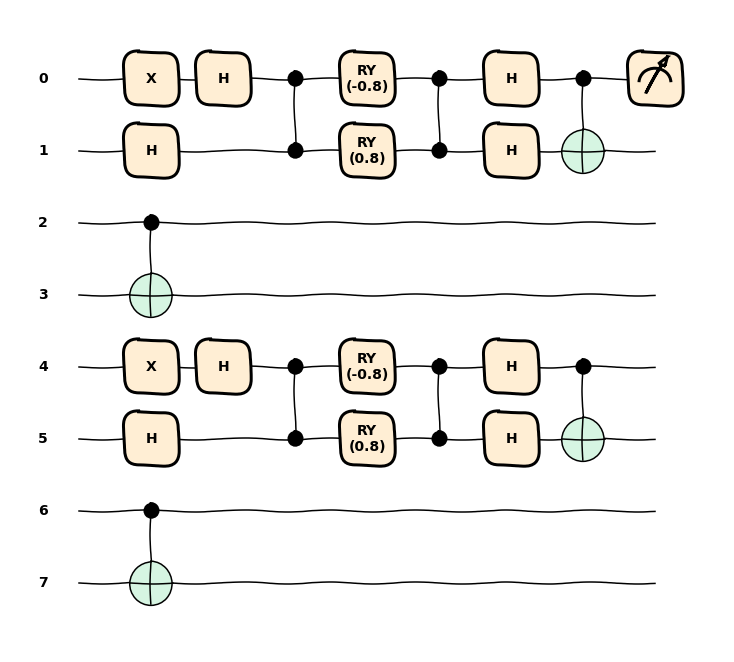

In [ ]:
qnode = qml.QNode(Circuit_global, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(torch.pi/4)
